# Sprint 1 — Jesse Traas (Group 23)

*Jesse's personal file for EDA and sprint tasks.*

## Table of contents
1. [EDA](#1-eda)  
  1.1 [General info](#11-general-info)  
  1.2 [Events and actions](#12-events-and-actions)  
  1.3 [Frequency of events](#13-frequency-of-events)  
2. [Common trace](#2-activity-type-prediction)  
  2.1 [Max trace](#21-max-trace)  
  2.2 [Common trace](#22-most-common-trace)  
3. [Case end time prediction](#3-case-end-time-prediction)  
  3.1 [Error checking](#31-error-checking)  
  3.2 [Output](#32-output)  
4. [Case end time prediction analysis](#4-case-end-time-prediction-analysis)

# 1. EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read the dataset
df = pd.read_csv('../Data/pm2017.csv', low_memory=False)
#df = df.loc[0:1000]

# Make datetimes datetimes
dt_format = '%Y/%m/%d %H:%M:%S.%f'
df_formatted = pd.to_datetime(df[['startTime', 'completeTime']].stack(), format=dt_format).unstack()

df['startTime'] = df_formatted['startTime']
df['completeTime'] = df_formatted['completeTime']

## 1.1 General info

In [6]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160405 entries, 0 to 1160404
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   case                   1160405 non-null  object        
 1   event                  1160405 non-null  object        
 2   startTime              1160405 non-null  datetime64[ns]
 3   completeTime           1160405 non-null  datetime64[ns]
 4   LoanGoal               1160405 non-null  object        
 5   ApplicationType        1160405 non-null  object        
 6   RequestedAmount        1160405 non-null  float64       
 7   Action                 1160405 non-null  object        
 8   FirstWithdrawalAmount  885870 non-null   float64       
 9   Accepted               885870 non-null   object        
 10  NumberOfTerms          885870 non-null   float64       
 11  OfferID                854361 non-null   object        
 12  org:resource           11604

,case,event,startTime,completeTime,LoanGoal,ApplicationType,RequestedAmount,Action,FirstWithdrawalAmount,Accepted,NumberOfTerms,OfferID,org:resource,MonthlyCost,EventOrigin,EventID,Selected,CreditScore,OfferedAmount
0,Application_652823628,A_Create Application,2016-01-01 10:51:15.304,2016-01-01 10:51:15.304,Existing loan takeover,New credit,20000.0,Created,NaN,NaN,NaN,NaN,User_1,NaN,Application,Application_652823628,NaN,NaN,NaN
1,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN
2,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN
3,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN
4,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN


## 1.2 Events and actions

In [7]:
df_time_event = df[['event', 'Action']]
df_time_event.describe()

,event,Action
count,1160405,1160405
unique,26,4
top,A_Complete,statechange
freq,157864,903416


## 1.3 Frequency of events

<AxesSubplot:title={'center':'Frequency of event types\n'}, ylabel='event'>

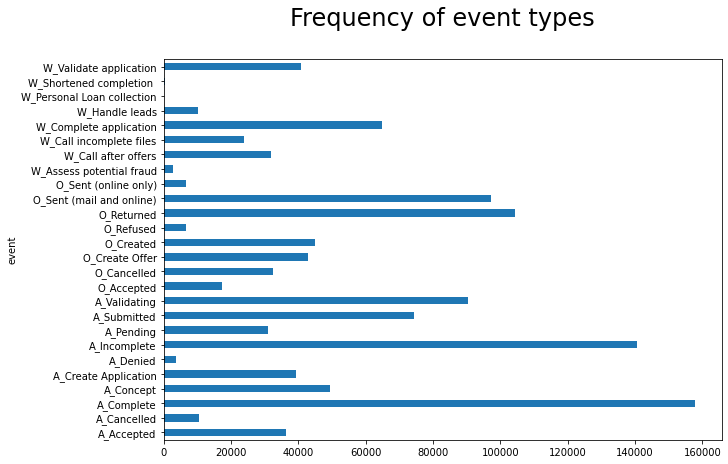

In [8]:
counts = df_time_event.sort_values(by='event', ascending=False).groupby(by='event')['event'].count()
plt.title('Frequency of event types\n', fontdict={'fontsize': 24})
counts.plot.barh(figsize=(10, 7))

# 2. Activity type prediction
The section below focusses on predicting the type of next activity. I thought it would be required for the prediction of the time until the end of the trace, but with the power of hindsight I can say this was not necessary. I kept it in this document for completeness' sake.

## 2.1 Max trace

In [9]:
df_grouped = df.groupby('case')
df_grouped_sorted_by_complete_date = df.sort_values('completeTime').groupby('case')
df_max_trace = df[df['case'] == df_grouped.size().idxmax()]
df_max_trace.describe()

,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
count,177.0,172.000000,172.000000,172.000000,172.000000,172.0
mean,23500.0,51.883721,117.872093,247.961395,263.662791,23500.0
std,0.0,48.523080,1.366230,4.244682,413.056942,0.0
min,23500.0,0.000000,117.000000,241.450000,0.000000,23500.0
25%,23500.0,0.000000,117.000000,241.450000,0.000000,23500.0
50%,23500.0,97.000000,117.000000,250.000000,0.000000,23500.0
75%,23500.0,97.000000,120.000000,250.000000,907.000000,23500.0
max,23500.0,97.000000,120.000000,251.830000,907.000000,23500.0


## 2.2 Most common trace
The block below constructs a sequence of size N (where N is the length of the longest trace) of the most common event types at the i-th position of any trace.

In [10]:
mct = []
for i in range(0, len(df_max_trace.index)):
    frequencies = df_grouped.nth(i)[['event']].value_counts()
    most_frequent = frequencies[0:1].index.tolist()[0][0]
    mct.append(most_frequent)

mct

['A_Create Application',
 'A_Submitted',
 'A_Submitted',
 'A_Submitted',
 'A_Submitted',
 'A_Concept',
 'W_Complete application',
 'W_Complete application',
 'O_Sent (mail and online)',
 'W_Call after offers',
 'O_Sent (mail and online)',
 'O_Sent (mail and online)',
 'O_Sent (mail and online)',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'A_Complete',
 'O_Returned',
 'O_Returned',
 'O_Returned',
 'O_Returned',
 'O_Returned',
 'O_Returned',
 'O_Returned',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 'A_Incomplete',
 '

# 3. Case end time prediction
This section is for attempting to estimate how long a trace will take from this particular event onwards to complete. It only uses the event type in the estimation.

The estimation is made by first grouping all events in the dataset by event type. Then, for every event in the groups it is checked how long it takes until the trace the event is in is completed. The average of the events in the group is taken, and that is considered the prediction for every event of that type.

In [11]:
# Generate case end time
df_trace_end = df_grouped_sorted_by_complete_date.tail(1)[['case', 'completeTime']]
df_trace_end = df_trace_end.rename(columns={"case": "case", "completeTime": "traceEnd"})

df_grouped_event_type = df.groupby('event')[['case', 'event', 'completeTime']]
df_event_differentials = pd.DataFrame(columns=['type', 'prediction_time_trace_end'])

for name, group in df_grouped_event_type:
    # Loop over all events of type `name` and get the complete time of their trace

    # Merge the current group with the trace_end data
    merged = group.merge(df_trace_end, on="case", how="outer")
    
    # Create a new series indicating the difference between the end of the trace and the completion of the current event
    diff_series = merged['traceEnd'] - merged['completeTime']

    # Add the time difference to the dataframe in seconds
    merged['differential (s)'] = diff_series
    merged['differential (s)'] = merged['differential (s)'].apply(lambda x: x.total_seconds())

    # Add the average differential to the dataframe
    df_group_diff = pd.DataFrame([[name, round(merged['differential (s)'].mean())]], columns=['type', 'prediction_time_trace_end'])
    df_event_differentials = pd.concat([df_event_differentials, df_group_diff], ignore_index=True)

df_event_differentials


,type,prediction_time_trace_end
0,A_Accepted,1785687
1,A_Cancelled,0
2,A_Complete,1717142
3,A_Concept,1967268
4,A_Create Application,1859999
5,A_Denied,0
6,A_Incomplete,762456
7,A_Pending,1114
8,A_Submitted,1992784
9,A_Validating,509759


## 3.1 Error checking
In the attempt above to predict the finish time of the request, some errors came up. The cells below are meant to check these.

### Problem: Some events happen after their trace ended
Some events have a negative time differential from the event itself to the trace end. This implies that the trace end value isn't correct. The cells below have been used to check this, and it seems like the cases are not by default sorted by completion time. This is required to get a correct `traceEnd` value, so sorting has been implemented in the cells above.

In [12]:
#df_grouped.get_group('Application_1691306052').sort_values('completeTime')

## 3.2 Output
This cell should produce the final output dataframe, to be exported to CSV!

In [13]:
result = df.merge(df_event_differentials, left_on='event', right_on='type', how='left')
result.head(10)

,case,event,startTime,completeTime,LoanGoal,ApplicationType,RequestedAmount,Action,FirstWithdrawalAmount,Accepted,NumberOfTerms,OfferID,org:resource,MonthlyCost,EventOrigin,EventID,Selected,CreditScore,OfferedAmount,type,prediction_time_trace_end
0,Application_652823628,A_Create Application,2016-01-01 10:51:15.304,2016-01-01 10:51:15.304,Existing loan takeover,New credit,20000.0,Created,NaN,NaN,NaN,NaN,User_1,NaN,Application,Application_652823628,NaN,NaN,NaN,A_Create Application,1859999
1,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN,A_Submitted,1992784
2,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN,A_Submitted,1992784
3,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN,A_Submitted,1992784
4,Application_652823628,A_Submitted,2016-01-01 10:51:15.352,2016-01-01 10:51:15.352,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_1582051990,NaN,NaN,NaN,A_Submitted,1992784
5,Application_652823628,A_Concept,2016-01-01 10:52:36.413,2016-01-01 10:52:36.413,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_1,NaN,Application,ApplState_642383566,NaN,NaN,NaN,A_Concept,1967268
6,Application_652823628,W_Complete application,2016-01-02 11:45:22.429,2016-01-02 11:45:22.429,Existing loan takeover,New credit,20000.0,Obtained,NaN,NaN,NaN,NaN,User_17,NaN,Workflow,Workitem_1875340971,NaN,NaN,NaN,W_Complete application,1890597
7,Application_652823628,W_Complete application,2016-01-02 11:45:22.429,2016-01-02 11:45:22.429,Existing loan takeover,New credit,20000.0,Obtained,NaN,NaN,NaN,NaN,User_17,NaN,Workflow,Workitem_1875340971,NaN,NaN,NaN,W_Complete application,1890597
8,Application_652823628,A_Accepted,2016-01-02 12:23:04.299,2016-01-02 12:23:04.299,Existing loan takeover,New credit,20000.0,statechange,NaN,NaN,NaN,NaN,User_52,NaN,Application,ApplState_99568828,NaN,NaN,NaN,A_Accepted,1785687
9,Application_652823628,O_Create Offer,2016-01-02 12:29:03.994,2016-01-02 12:29:03.994,Existing loan takeover,New credit,20000.0,Created,20000.0,True,44.0,NaN,User_52,498.29,Offer,Offer_148581083,True,979.0,20000.0,O_Create Offer,1722185


# 4. End of case prediction analysis
This section is meant to check how good this estimation actually is.

Error percentage of full dataset


,error_percentage
count,1.160405e+06
mean,8.392821e+05
std,6.082303e+06
min,-1.000000e+02
25%,-3.000000e+01
50%,4.200000e+01
75%,1.920000e+02
max,1.890596e+08


Error percentage capped at 5000, for plotting purposes


,error_percentage
count,1.043739e+06
mean,1.534720e+02
std,5.187544e+02
min,-1.000000e+02
25%,-3.300000e+01
50%,2.400000e+01
75%,1.250000e+02
max,4.999000e+03


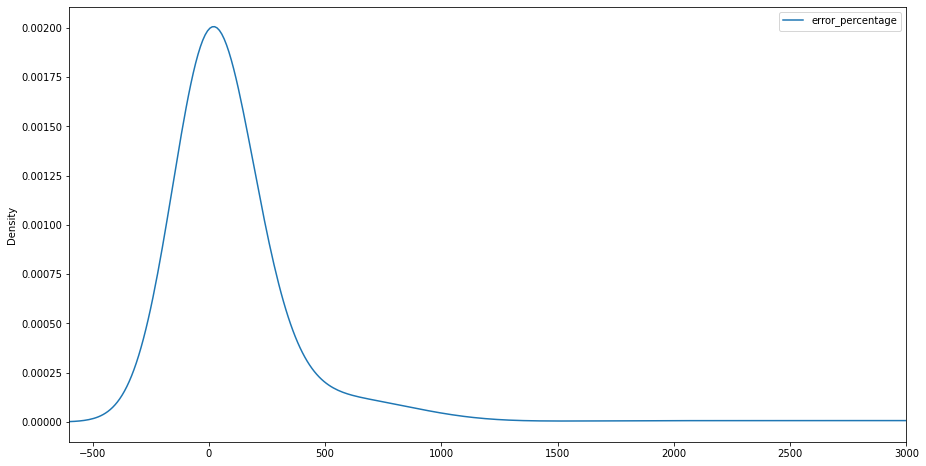

In [14]:
r_analysis = result.merge(df_trace_end, on='case', how='left')
diff_series = r_analysis['traceEnd'] - r_analysis['completeTime']

# Add the time difference to the dataframe in seconds
r_analysis['time_trace_end'] = diff_series.apply(lambda x: round(x.total_seconds()) if round(x.total_seconds()) != 0 else 1 )
r_analysis['error_percentage'] = round(((r_analysis['prediction_time_trace_end'] - r_analysis['time_trace_end']) / r_analysis['time_trace_end'] * 100).astype(int))
r_analysis.head(10)

r_analysis_plot = r_analysis[r_analysis['error_percentage'] < 5000]
ax = r_analysis_plot.plot.kde(y='error_percentage', use_index=True, figsize=(15, 8), bw_method=0.3)
ax.set_xlim(-600, 3000)
ax

print("Error percentage of full dataset")
display(r_analysis[['error_percentage']].describe())
print("Error percentage capped at 5000, for plotting purposes")
r_analysis_plot[['error_percentage']].describe()

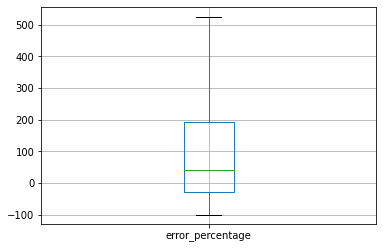

In [15]:
ax_bp = r_analysis.boxplot(column='error_percentage', showfliers=False)

## Analysis conclusion
This "naïve" or "baseline" prediction is not too great. The error percentage without outliers, of which the distribution is shown in the boxplot above, indicates that the baseline is commonly off, and tends to overestimate the completion time of the case. The biggest problem is that there are some insane outliers, the worst having an error percentage of *180 million*.